# MERCS for Feature Selection

Using MERCS' composite models for feature 

# Prelims

Preliminaries for rest of notebook.

In [1]:
# (Optional) Black codeformatter (`pip install nb_black`) for jupyterlab. In jupyter notebook, this changes slightly.
%load_ext lab_black

## Imports

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
from mercs import Mercs
import shap

## Constants

In [4]:
ROOT_DIR = Path().resolve().parent.parent
DATA_DIR = ROOT_DIR / "data" / "raw"
DEMO_DIR = DATA_DIR / "demo"

In [5]:
NOMINAL_THRESHOLD = 10

# Custom model for a query-code

## Data

In [6]:
titanic_fp = DEMO_DIR / "titanic.csv"
titanic_fp.exists()

df = pd.read_csv(titanic_fp)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
usable_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c].dtype)]
df2 = df[usable_cols].copy()
df2.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [8]:
df2["Survived"] = df.Survived
df2 = df2[
    [c for c in df2.columns if c not in {"Survived", "PassengerId"}] + ["Survived"]
]
df2.head()

,Pclass,Age,SibSp,Parch,Fare,Survived
0,3,22.0,1,0,7.2500,0
1,1,38.0,1,0,71.2833,1
2,3,26.0,0,0,7.9250,1
3,1,35.0,1,0,53.1000,1
4,3,35.0,0,0,8.0500,0


In [9]:
df2.dropna(inplace=True)

In [10]:
X = df2.values
X[:5, :]

array([[ 3.    , 22.    ,  1.    ,  0.    ,  7.25  ,  0.    ],
       [ 1.    , 38.    ,  1.    ,  0.    , 71.2833,  1.    ],
       [ 3.    , 26.    ,  0.    ,  0.    ,  7.925 ,  1.    ],
       [ 1.    , 35.    ,  1.    ,  0.    , 53.1   ,  1.    ],
       [ 3.    , 35.    ,  0.    ,  0.    ,  8.05  ,  0.    ]])

## Mercs

In [11]:
nominal_attributes = {X.shape[1] - 1}
nominal_attributes

{5}

In [12]:
cfg_mercs_default = dict(
    # Induction
    max_depth=8,
    selection_algorithm="random",
    nb_targets=1,
    nb_iterations=10,
    fraction_missing=0.4,
    n_jobs=1,
    # Inference
    inference_algorithm="own",
    prediction_algorithm="rw",
    max_steps=8,
    nb_walks=5,
    # Metadata
    nominal_attributes=nominal_attributes,
)

# Train a MERCS-model with config above
clf = Mercs(**cfg_mercs_default)

# Nominal attributes has to be given at fit, all the rest can be done before
clf.fit(X, nominal_attributes=nominal_attributes)

10 iterations means that every target has 10 models that predict that target. Given that we have 6 attributes in total, we get 60 models:

In [13]:
len(clf.m_codes)

60

And, since we set fraction_missing=0.4, each model has more or less 2 attributes missing (2 being more or less 40 percent of 6)

In [14]:
np.mean(np.sum(clf.m_codes == -1, axis=1))

2.066666666666667

Other options for `fraction_missing` include `log2` or `sqrt` which then take the total amount of attributes into account. This way of subsetting features is essentially standard in RF as well, so that's why they are available.

Note however that if you set it to `sqrt` it means that `sqrt(n_attributes)` will be the amount of _descriptive_ attributes.


Another thing you can do, if you need more control, is manually specifiy the exact amount of missing attributes using the `nb_missing_attributes` parameter, which overrides the `fraction_missing` parameter.

In [15]:
cfg_mercs_default = dict(
    # Induction
    max_depth=8,
    selection_algorithm="random",
    nb_targets=1,
    nb_iterations=10,
    fraction_missing=0.0,
    nb_missing_attributes=3,
    n_jobs=1,
    # Inference
    prediction_algorithm="rw",
    max_steps=8,
    nb_walks=5,
    # Metadata
    nominal_attributes=nominal_attributes,
)

# Train a MERCS-model with config above
clf = Mercs(**cfg_mercs_default)

# Nominal attributes has to be given at fit, all the rest can be done before
clf.fit(X, nominal_attributes=nominal_attributes)


avg_missing_attributes_per_model = np.mean(np.sum(clf.m_codes == -1, axis=1))

msg = """
AVERAGE AMOUNT OF MISSING ATTRIBUTES PER MODEL: {}
""".format(
    avg_missing_attributes_per_model
)
print(msg)


AVERAGE AMOUNT OF MISSING ATTRIBUTES PER MODEL: 2.9833333333333334



So that also works, basically.

Also please note for all this stuff, you really do need to set
```
selection_algorithm="random"
```

since otherwise all attributes are taken to be inputs.

## Predict


Given that the settings for prediction are the following:

```
    prediction_algorithm="rw",
    max_steps=8,
    nb_walks=5,
```

You are using the random walks prediction algorithm, with 5 walks of maximum 8 steps. That means that you are making 5 random chains, each chain consisting of maximally 8 individual decision trees. Each chain predicts the target. The final prediction is an average of those 5 predictions.

All of these chains together form what we call a `query_model`, since it is just a composite model, tailor-made by MERCS for _your_ query-code.

Allow me to give you a tiny demonstration,

In [16]:
X.shape

(714, 6)

In [17]:
q_code = np.array([-1, -1, 0, -1, 0, 1])
clf.predict(X, q_code=q_code)[:10]

array([0., 1., 0., 1., 0., 0., 0., 0., 1., 1.])

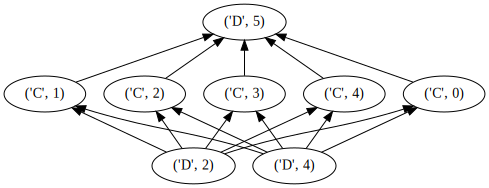

In [18]:
# For this to work, you need graphviz installed on your machine!
clf.show_q_diagram()

The `C`nodes stand for composite. The chains themselves are composite models and are not visualized in detail. However, if you must:

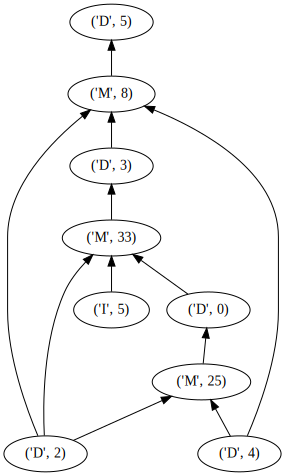

In [19]:
clf.show_q_diagram(index=2)

This is how the `(c,2)` node looks internally.

Now, let us touch the query model for real:

In [20]:
qmod = clf.q_model
qmod

Indeed, it's a composite model, as I said it was.

Let us inspect a few attributes:

In [21]:
qmod.desc_ids, qmod.targ_ids, qmod.out_kind

([2, 4], [5], 'nominal')

One other thing is the following, either you must give the correct inputs to the query model, if you call it directly:

In [22]:
y_pred = qmod.predict(X[:, qmod.desc_ids])
y_pred[:10]

array([0., 1., 0., 1., 0., 0., 0., 0., 1., 1.])

# SHAP Avatar Function

So, now you have your MERCS model, and your queries. Furthermore, you know that given a query, a mercs model generates a custom query model for you.

Evidently, now we just need SHAP values of this query model, and we'd know which features matter and which ones do not.

In [23]:
cfg_mercs_default = dict(
    # Induction
    max_depth=8,
    selection_algorithm="random",
    nb_targets=1,
    nb_iterations=10,
    fraction_missing=0.0,
    nb_missing_attributes=3,
    n_jobs=1,
    # Inference
    prediction_algorithm="rw",
    max_steps=8,
    nb_walks=5,
    # Metadata
    nominal_attributes=nominal_attributes,
    random_state=30,
)

X_train = X[:500, :]
X_test = X[500:, :]

# Train a MERCS-model with config above
clf = Mercs(**cfg_mercs_default)

# Nominal attributes has to be given at fit, all the rest can be done before
clf.fit(X_train, nominal_attributes=nominal_attributes)

In [24]:
# Giving a q_code and making a prediction
q_code = np.array([-1, -1, 0, -1, 0, 1])
clf.predict(X_test, q_code=q_code)[:20]

array([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [25]:
clf.predict(X_test[:100, :], q_code=q_code)[:20]

array([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

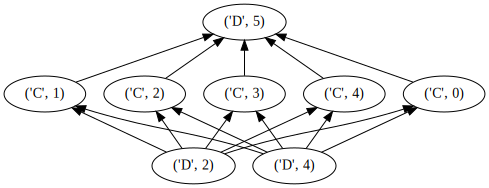

In [26]:
clf.show_q_diagram()

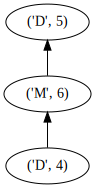

In [27]:
clf.show_q_diagram(index=1)

## Extracting nrm_shaps

You need to give training data and testing data to calculate the SHAP values now.

The training data can be the data that you you used in fit. The `n_samples`parameter subsamples this. I have found that you do not need to set too many samples for accurate results. Setting `n_samples` too high really hits runtime bad.

The testing data is exactly what you expect it to be. It is the data you use in the mercs.predict (if you were not too lazy to do a train-test split)

If you give 200 testing samples, the shap calculation will calculate 200 predictions, and internally, they're will be 200 abs_shaps values. Those are averaged and normalized and that process yields the nrm_shaps as you see here.

In [28]:
%%timeit
nrm_shaps = clf.avatar_q_model(X_train, X_test, n_samples=50)

1.02 s ± 58.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
clf.avatar_q_model(X_train, X_test, n_samples=50)

array([0.0425927, 0.9574073])

In [30]:
%%timeit
nrm_shaps = clf.avatar_q_model(X_train, X_test, n_samples=5)

879 ms ± 6.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
clf.avatar_q_model(X_train, X_test, n_samples=5)

array([0.03745447, 0.96254553])

In [32]:
clf.avatar_q_model(X_train, X_test[:50], n_samples=5)

array([0.05171342, 0.94828658])

Smaller test set is even way faster AND the results seem also semi-close

# SHAP Avatar Function with different predict

Just FYI, the iterative prediction algorithm in mercs is also quite powerful (also does chaining and is somewhat faster)

Instead of a chain, it makes a pyramid of decision trees. By that, I mean a single chain, but every level of the chain is allowed to contain multiple trees. But overall, this algorithm will end up using less decision trees than the random walk algorithm. To see why, just realize that the 'it' algorithm can only use each decision tree once. In the random walk prediction, a single decision tree can be used a lot.

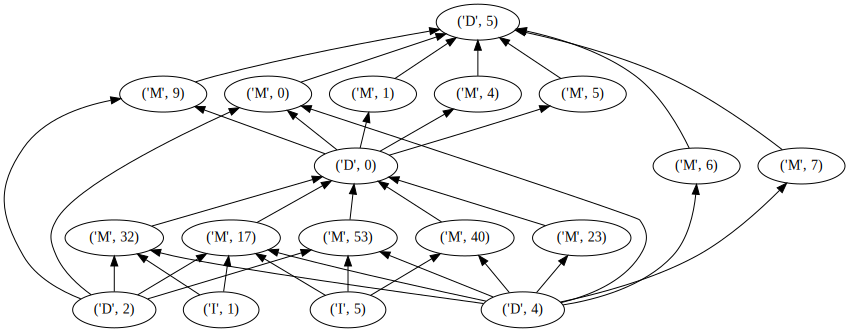

In [33]:
cfg_mercs_default = dict(
    # Induction
    max_depth=8,
    selection_algorithm="random",
    nb_targets=1,
    nb_iterations=10,
    fraction_missing=0.0,
    nb_missing_attributes=3,
    n_jobs=1,
    # Inference
    prediction_algorithm="it",
    max_steps=4,
    stepsize=0.1,
    # Metadata
    nominal_attributes=nominal_attributes,
    random_state=30,
)

X_train = X[:500, :]
X_test = X[500:, :]

# Train a MERCS-model with config above
clf = Mercs(**cfg_mercs_default)

# Nominal attributes has to be given at fit, all the rest can be done before
clf.fit(X_train, nominal_attributes=nominal_attributes)

# Giving a q_code and making a prediction
q_code = np.array([-1, -1, 0, -1, 0, 1])
clf.predict(X_test, q_code=q_code)[:20]

clf.show_q_diagram()

In [40]:
%%timeit
clf.avatar_q_model(X_train, X_test[:10], n_samples=1)

52 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
%%timeit
dt = DecisionTreeClassifier()
dt.fit(X[:, q_code == 0], X[:, -1])

909 µs ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Interestingly enough, this one is also super close to what we found before, even though the composition is quite different!

So, maybe it does work after all...